# Cancer binary classification: fc + bn + dropout

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.externals import joblib
from collections import Counter

import pathlib as plib
import pdb
import types

In [2]:
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

In [3]:
#Globals
ROOT = plib.Path("/root/fastai/Playground/PytorchStarter/")
nRuns = 5 #number of test runs per unit
RSEED = 11;

In [4]:
cd $ROOT

/root/fastai/Playground/PytorchStarter


In [5]:
# To list all packages imported
list(imports())

['builtins',
 'builtins',
 'torch',
 'torch.nn',
 'torch.optim',
 'torch.nn.functional',
 'numpy',
 'matplotlib.pyplot',
 'pandas',
 'sklearn.externals.joblib',
 'pathlib',
 'pdb',
 'types']

## Load cancer dataset (binary classification)

In [6]:
from sklearn.datasets import load_breast_cancer

In [7]:
cancer_xy = load_breast_cancer()
cancer_x = cancer_xy.data
cancer_y = cancer_xy.target
print(cancer_x.shape, cancer_y.shape)
print("classes: ", np.unique(cancer_y))

(569, 30) (569,)
classes:  [0 1]


In [8]:
pd.DataFrame(cancer_x).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Define cancer dataset, dataloader

In [9]:
class CancerDataset(Dataset):
    def __init__(self, xy, ids, transform=None ):
        self.ids = ids
        self.len = len(ids)
        self.data = xy.data
        self.targets = xy.target
        self.transform = transform
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        """Returns a sample = [data[idx], targets[idx], idx]"""
        ID = self.ids[idx]
        sample = [self.data[ID], self.targets[ID], idx]
        
        if self.transform:
            sample = self.transform(sample)
        return sample

Divide the indices into train, dev, test


In [10]:
dataset = CancerDataset(cancer_xy, range(len(cancer_xy)))

#### First, partition the dataset into train, dev, test sets

In [11]:
from sklearn.model_selection import train_test_split 
labels = dataset.targets
indices = range(len(labels))
train_dev_ids, test_ids = train_test_split(indices,
                                        stratify=labels,
                                        test_size=0.1, 
                                        random_state=RSEED) #stratified 

In [12]:
def print_counts(indices, labels, categories):
    #todo
    """Check ratio of 0's and 1's in the labels selected by 'indices'
    Args:
    ---
    - indices: 1D array for selected indices of labels
    - labels: an array of 0s and 1s (if binary) or 0,...,K-1 indicating each class label
    Note len(labels) >= len(indices)
    - categories (1D array): array of class labels to compute the ratio 
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
        
    print([sum(filtered==categories[i]) for i in range(len(categories))])
    
def print_ratios(indices, labels, categories):
    """Check ratio of 0's and 1's in the labels selected by 'indices'
    Args:
    ---
    - indices: 1D array for selected indices of labels
    - labels: an array of 0s and 1s (if binary) or 0,...,K-1 indicating each class label
    Note len(labels) >= len(indices)
    - categories (1D array): array of class labels to compute the ratio 
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
    n = len(filtered)
        
    print([sum(filtered==categories[i])/n for i in range(len(categories))])

In [13]:
categories = np.unique(dataset.targets)
print("class labels: ", categories)
print_ratios(train_dev_ids, labels, categories)
print_ratios(test_ids, labels, categories)

class labels:  [0 1]
[0.373046875, 0.626953125]
[0.3684210526315789, 0.631578947368421]


In [14]:
# partition train_ids into train_ids and dev_ids
train_dev_labels = labels[train_dev_ids]
indices = range(len(train_dev_ids))
train_ids, dev_ids = train_test_split(indices, 
                                     stratify=train_dev_labels,
                                     test_size=0.2,
                                     random_state=RSEED)
imax = max(max(train_ids, dev_ids))
imin = min(min(train_ids, dev_ids))
print(f"min and max indices should corresponds to 0 and {len(train_dev_labels)-1}: {imin, imax}")

# map it back to index to (the original) y
train_ids = np.array(train_dev_ids)[train_ids]
dev_ids = np.array(train_dev_ids)[dev_ids]

# make test_ids also a np array
test_ids = np.array(test_ids)

min and max indices should corresponds to 0 and 511: (3, 511)


In [15]:
# check ratios
for index_array in [train_ids, dev_ids, test_ids]:
    print_ratios(index_array, labels, categories)
    
        
# intersection check
s1 = set(train_ids); s2 = set(dev_ids); s3 = set(test_ids)
assert( len(s1.intersection(s2).intersection(s3)) == 0)

[0.3740831295843521, 0.6259168704156479]
[0.36893203883495146, 0.6310679611650486]
[0.3684210526315789, 0.631578947368421]


Train, Dev, Test sizes

In [16]:
print([len(ids) for ids in [train_ids, dev_ids, test_ids]])

[409, 103, 57]


Woohoo!

## Define Luna dataset and dataloader objects

First, define a transformation from numpy -> torch.FloatTensor

In [17]:
class npToFloatTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        datum, target, idx = sample #np.ndarray, an integer, idx to __getitem__ of Dataset
#         pdb.set_trace()
        
        datum = torch.from_numpy(datum).type(torch.float) #float32
        
        # BCLoss takes in both int and float tensor
        # CrossEntropyLoss requires target to be LongTensor, ie. int
        target = torch.tensor(target, dtype=torch.float)
        #todo: to int?
        return (datum, target, idx)

In [18]:
partition = {'train': train_ids, 
             'dev': dev_ids, 
             'train_dev': train_dev_ids,
             'test': test_ids}

In [19]:
# train_dataset = LunaPickleDataset(fpath, 
#                                   partition['train'], 
#                                   root_dir=ROOT,
#                                   transform=npToFloatTensor()
#                                  )
# dev_dataset = LunaPickleDataset(fpath, 
#                                 partition['dev'],
#                                 root_dir=ROOT,
#                                 transform=npToFloatTensor())

# test_dataset = LunaPickleDataset(fpath, 
#                                  partition['test'], 
#                                  root_dir=ROOT,
#                                  transform=npToFloatTensor())

In [20]:
train_dataset = CancerDataset(cancer_xy, 
                              partition['train'], 
                              transform=npToFloatTensor())
dev_dataset = CancerDataset(cancer_xy, 
                            partition['dev'],
                            transform=npToFloatTensor())

train_dev_dataset = CancerDataset(cancer_xy, 
                            partition['train_dev'],
                            transform=npToFloatTensor())

test_dataset = CancerDataset(cancer_xy, 
                            partition['test'], 
                            transform=npToFloatTensor())

In [21]:
dev_dataset[0]

(tensor([ 1.3690e+01,  1.6070e+01,  8.7840e+01,  5.7910e+02,  8.3020e-02,
          6.3740e-02,  2.5560e-02,  2.0310e-02,  1.8720e-01,  5.6690e-02,
          1.7050e-01,  5.0660e-01,  1.3720e+00,  1.4000e+01,  4.2300e-03,
          1.5870e-02,  1.1690e-02,  6.3350e-03,  1.9430e-02,  2.1770e-03,
          1.4840e+01,  2.0210e+01,  9.9160e+01,  6.7060e+02,  1.1050e-01,
          2.0960e-01,  1.3460e-01,  6.9870e-02,  3.3230e-01,  7.7010e-02]),
 tensor(1.),
 0)

In [22]:
# Dataloader instances
train_loader_params = {'batch_size': 32,
              'shuffle': True,
              'num_workers':4}

train_loader = DataLoader(dataset=train_dataset, **train_loader_params)
train_dev_loader = DataLoader(dataset=train_dev_dataset, **train_loader_params)

## Each loads its entire dataset in a single iteration
heavy_train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_ids), shuffle=False)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=len(dev_ids), shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_ids), shuffle=False)

#### Test loaders

In [23]:
for loader in [train_loader, train_dev_loader, dev_loader, test_loader ]:
    print('num cycles: ', len(loader))
#     dataiter = iter(loader)
#     print('dtype: ', type(dataiter.next()[0][0]))
#     print(dataiter.next())


num cycles:  13
num cycles:  16
num cycles:  1
num cycles:  1


Ready!

##  Try a deeper network

Simple dropout layer 

In [24]:
dropout = nn.Dropout(p=0.5)
xsample = torch.rand(4,3);print('in: \n', xsample)
yout = dropout(xsample); print('out: \n', yout)

in: 
 tensor([[ 0.3394,  0.1028,  0.9968],
        [ 0.3285,  0.3713,  0.1801],
        [ 0.5952,  0.0445,  0.7342],
        [ 0.3644,  0.7636,  0.1619]])
out: 
 tensor([[ 0.0000,  0.0000,  1.9936],
        [ 0.0000,  0.7427,  0.0000],
        [ 1.1904,  0.0891,  1.4683],
        [ 0.7288,  1.5273,  0.3238]])


In [25]:
N,D =  train_dataset.len, train_dataset.data.shape[1]
criterion = nn.BCELoss(size_average=True)

In [26]:
class DeepBCModel(nn.Module):
    def __init__(self, dims, 
                hidden_activation=nn.ReLU(), 
                output_activation=nn.Sigmoid(),
                p_dropout=None
                ):
        """
        Args:
        ----
        - dims (list): a list of dimensions of layer. [inDims, H1, H2,...].
        It doesn't include the output layer's size, which is fixed to 1

        - hidden_activation (nn.modules.activation instance): for hidden units
        - output_activation (nn.modules.activation instace):  for output unit
        - p_dropout (None or float in [0,1]): probability for hidden dropout units
        """
        
        super(DeepBCModel,self).__init__()
        
        self.n_layers = len(dims)
        self.n_batch_norms = self.n_layers - 1 # Q:don't need for the last layer(right before softmax)
        
        self.p_dropout = p_dropout
        if self.p_dropout is None:
            self.do_dropout = False
        else: 
            self.do_dropout = True
            
        self.__build_layers__(dims)

        self.h_activation = hidden_activation
        self.o_activation = output_activation
        
    def __build_layers__(self, dims):

        for i in range(len(dims)-1):
            self.add_module(f'li{i}', nn.Linear(dims[i],dims[i+1]))
            self.add_module(f'bn{i}', nn.BatchNorm1d(dims[i+1]))
            if self.do_dropout:
                self.add_module(f'dropout{i}', nn.Dropout(p=self.p_dropout))
        self.add_module(f'li{len(dims)-1}', nn.Linear(dims[-1],1))
        
    def forward(self, x):
        y_pred = x

        for i in range(self.n_layers - 1): #exclude the last weight
            li = getattr(self, f"li{i}")
            bn = getattr(self, f"bn{i}")
            y_pred = self.h_activation(bn(li(y_pred)))
            
            if self.do_dropout:
                dropout = getattr(self, f"dropout{i}")
                y_pred = dropout(y_pred)

        li = getattr(self, f"li{self.n_layers-1}")
        y_pred = self.o_activation(li(y_pred))

        return y_pred


In [27]:
def get_train_loss(model, criterion, train_dataset, exclude_indices):
    """
    Compute loss on training dataset except data indexed at
    exclude_indices.
    Args:
    - model: trained model with forward function
    - criterion: loss function that takes in (ypred, y)
    - train_dataset (Dataset): training dataset 
    - exclude_indices: indices to exclude from train_dataset 
        when computing the loss, eg: batch indices used to 
        fit the current model
    """
    n = len(train_dataset)
    if isinstance(exclude_indices, torch.Tensor):
        exclude_indices = exclude_indices.numpy()
    include_indices = [i for i in range(n) if i not in exclude_indices]
    samples = train_dataset[include_indices]
    x = samples[0]
    y = samples[1]
#     pdb.set_trace()
#     x_tensor = torch.tensor(x)
#     y_tensor = torch.stack(y)
#     pdb.set_trace()
    with torch.no_grad():
        ypred = model(x).type_as(y)
        loss = criterion(ypred, y).item()
    return loss  

In [28]:
def get_loss_on_entire_dataset(model, criterion, loader):
    """Assumes dataset has a batch_size == len(dataset),
    ie. one iter results in iterating the entire dataset."""
    n = len(loader.dataset)
    assert(n == loader.batch_size)
    
#     print(model.li4.bias[:10])
#             pdb.set_trace()

    with torch.no_grad():
        loss = 0
        acc = 0 #general acc
        hit_accs = [] #acc per label

        for x, y, _ in loader:
            ypred = model(x).view(y.size()).type_as(y)
            loss = criterion(ypred, y).item()
            
            # make a decision at 0.5
            # boolean tensor is uint8 type. Cast it to tensor.float32
            decision = (ypred > 0.5).view(y.size()).type(y.dtype)
            isCorrect = (decision==y).numpy()
            acc = sum(isCorrect)/len(isCorrect)

            # 0->0 accuracy, 1->1 accuracy
            for label in y.unique():
                hit_count = [1 for i in range(n) if decision[i]==label and y[i]==label]
                hit_acc = sum(hit_count) / (y==label).sum().item() #sum(y==label).item()
                hit_accs.append(hit_acc)
    return [loss, acc, hit_accs]

In [29]:
def show_weights(model, ncols=3, figsize=(20,10)):
    # visualize weights
    n = model.n_layers
#     pdb.set_trace()
    nrows = int(np.floor(n/ncols))
    f,axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    i = 0
    for mname,m in model.named_children():
        if isinstance(m, nn.Linear):
            w = m.weight.data.numpy()
            if w.shape[0] == 1 or w.shape[1] == 1:
                w = w.reshape((-1,10))

            print (f'{mname}: {w.min(), w.max()}')
            axes[i].set_title(mname)
            axes[i].axis('off')
            axes[i].imshow(w)
            i += 1
    plt.show()

- Test DeepBCModel constructor

In [30]:
N,D =  train_dataset.len, train_dataset.data.shape[1]

dims = [D, 200,200,200]
M1 = DeepBCModel(dims) #fc+bn
M2 = DeepBCModel(dims, p_dropout=0.2) #bn+fc+dropout
criterion = nn.BCELoss(size_average=True)

print(M1)
print(M1.n_layers)

print("="*30)
print(M2)
print(M2.n_layers)

DeepBCModel(
  (li0): Linear(in_features=30, out_features=200, bias=True)
  (bn0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li1): Linear(in_features=200, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li2): Linear(in_features=200, out_features=200, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li3): Linear(in_features=200, out_features=1, bias=True)
  (h_activation): ReLU()
  (o_activation): Sigmoid()
)
4
DeepBCModel(
  (li0): Linear(in_features=30, out_features=200, bias=True)
  (bn0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout0): Dropout(p=0.2)
  (li1): Linear(in_features=200, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2)
  (li2): Linear(in_features=200, out_feat

In [31]:
# check forward function
dataiter = iter(train_loader)
x1, y1, idx = dataiter.next();

In [32]:
M1(x1);

In [33]:
M2(x1);

- Test get_train_loss


In [35]:
excludes = range(32)
get_train_loss(M1, criterion, train_dataset, excludes)

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([377])) that is different to the input size (torch.Size([377, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0.7390124797821045

### Experiment: fc + bn + dropout 

In [36]:
# Hyperparameters
learning_rate = 0.0001
nEpoch = 1000
H1 = 100; H2 = 100;# H3 = 50; H4 = 50
dims = [D, H1, H2]#, H3, H4]
plt.ion() # turn on interactive mode

In [37]:
model = DeepBCModel(dims, p_dropout=0.2)
model_name = 'cancer_fc_bn_dropout0.2'
# model.apply(weight_init)

li0: (-0.18254733, 0.18254283)
li1: (-0.09997324, 0.09994439)
li2: (-0.097912006, 0.09950016)


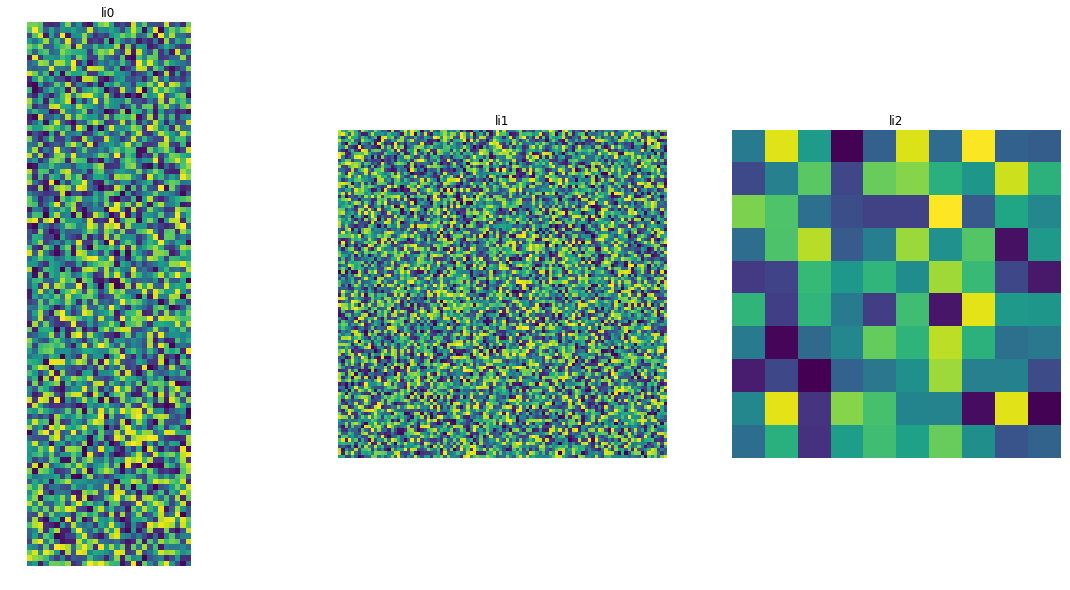

In [38]:
# visualize first layer's initial weight
show_weights(model)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Save and load model   
See [sor](http://bit.ly/2uo4zt9), [pytorch forum](http://bit.ly/2zrvTg1)
1. Save 
```pytorch
torch.save(the_model.state_dict(), PATH)
```
2. Load
```pytorch
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))
```

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([377])) that is different to the input size (torch.Size([377, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([384])) that is different to the input size (torch.Size([384, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0
train loss, acc: (0.6422855854034424, 0.68)
epoch train loss: 0.6424017548561096
dev loss, acc: (0.6545684337615967, 0.6407766990291263)
li0: (-0.18292621, 0.18267715)
li1: (-0.101027936, 0.101167515)
li2: (-0.099193595, 0.099288195)


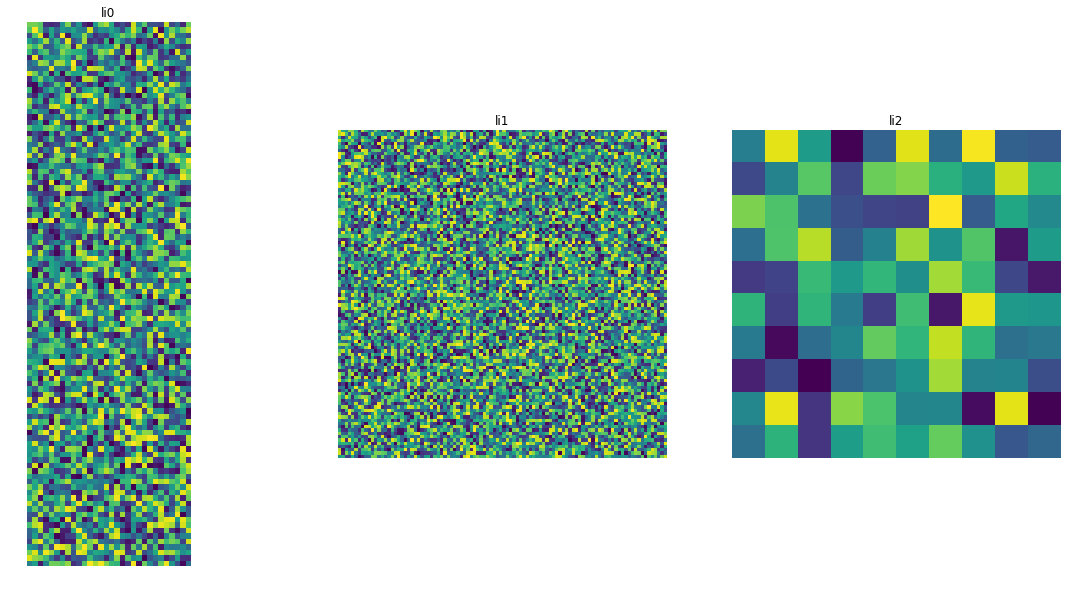

epoch 49
train loss, acc: (0.22216437757015228, 0.84)
epoch train loss: 0.2316528707742691
dev loss, acc: (0.2742900550365448, 0.9223300970873787)
epoch 98
train loss, acc: (0.15036936104297638, 0.96)
epoch train loss: 0.13581755757331848
dev loss, acc: (0.1819184571504593, 0.9514563106796117)
epoch 147
train loss, acc: (0.10611448436975479, 0.92)
epoch train loss: 0.10780911892652512
dev loss, acc: (0.14982987940311432, 0.941747572815534)
epoch 196
train loss, acc: (0.10170812159776688, 0.96)
epoch train loss: 0.09233616292476654
dev loss, acc: (0.1498386412858963, 0.9320388349514563)
epoch 245
train loss, acc: (0.08749892562627792, 0.92)
epoch train loss: 0.07825618237257004
dev loss, acc: (0.1441289633512497, 0.941747572815534)
epoch 294
train loss, acc: (0.08441435545682907, 1.0)
epoch train loss: 0.08699768781661987
dev loss, acc: (0.13106568157672882, 0.9514563106796117)
epoch 343
train loss, acc: (0.06953852623701096, 0.96)
epoch train loss: 0.08144860714673996
dev loss, acc: (0

In [ ]:
# Train
debug = False
verbose = True

# loss and acc from each batch (ie. per cycle)
batch_ls = []
train_ls = []
batch_accs = []
batch_hit_accs = []

# loss and acc from each epoch (ie. per epoch)
dev_ls = []
dev_accs = []
epoch_dev_hit_accs = []

epoch_train_ls = []

model.train()
for epoch in range(nEpoch):
    for i, (x_batch, y_batch, i_batch) in enumerate(train_loader):
        if debug:
            print(x_batch.size())
            print(y_batch.size())
            print(i_batch.size())
            pdb.set_trace()

        #forward
        ypred_batch = model(x_batch).view(y_batch.size())
        
        #loss
        l = criterion(ypred_batch, y_batch)
        batch_ls.append(l.item())
        
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
        
        if debug:
            print(ypred_batch.size(), ypred_batch.dtype)
            print(y_batch.size(), y_batch.dtype)
            print(i_batch)
            pdb.set_trace()
            
        # Compute training loss and accuracy
        train_l = get_train_loss(model, criterion, train_dataset, i_batch)
        train_ls.append(train_l)
        
        # make a decision at 0.5
        # boolean tensor is uint8 type. Cast it to tensor.float32
        decision_batch = (ypred_batch > 0.5).view(y_batch.size()).type(y_batch.dtype)
        isCorrect_batch = (decision_batch==y_batch).numpy()
        batch_acc = sum(isCorrect_batch)/len(isCorrect_batch)
        batch_accs.append(batch_acc)

        # 0->0 accuracy, 1->1 accuracy
        batch_size = len(y_batch)
        hit_accs = []
        for label in y_batch.unique():
            hit_count = [1 for i in range(batch_size) if decision_batch[i]==label and y_batch[i]==label]
#             pdb.set_trace()
            hit_acc = sum(hit_count) / (y_batch==label).sum().item() #sum(y_batch==label).item()
            hit_accs.append(hit_acc)
        # collect hit_accs from each cycle
        batch_hit_accs.append(hit_accs)
        
    # Dev accuracy
    epoch_train_l, _, _ = get_loss_on_entire_dataset(model, 
                                               criterion, 
                                               loader=heavy_train_loader)
    
    dev_l, dev_acc, dev_hit_accs = get_loss_on_entire_dataset(model, 
                                                              criterion, 
                                                              loader=dev_loader)
    dev_ls.append(dev_l)
    dev_accs.append(dev_acc)
    epoch_dev_hit_accs.append(dev_hit_accs)
    
    epoch_train_ls.append(epoch_train_l)
    
    if (verbose and epoch%49 == 0):
        print("="*80); print(f'epoch {epoch}')
        print(f"train loss, acc: {train_ls[-1], batch_accs[-1]}")
        print(f"epoch train loss: {epoch_train_ls[-1]}")
        print(f"dev loss, acc: {dev_ls[-1], dev_accs[-1]}")
    
    if verbose and (epoch==0 or epoch==nEpoch-1):
        # visualize weights
        show_weights(model)
   
    
    # todo: accuracy on all training dataset
# save current trained model
from time import gmtime, strftime

time_str = strftime("%Y_%m_%d_%H_%M", gmtime())
outpath = f'TrainedModel/{model_name}_{time_str}.pth.tar'
torch.save(model.state_dict(), ROOT/outpath )
print(f'Saved {model_name} to {outpath}')

In [ ]:
f,axes = plt.subplots(3,1,figsize=(20,20))
axes = axes.flatten()
axes[0].plot(batch_ls, 'r', label='batch loss')
axes[0].plot(train_ls, 'b', label='train loss')
axes[1].plot(batch_accs, label='train acc')

axes[2].plot(dev_ls, label='dev loss') #Devset error
axes[2].plot(epoch_train_ls, label='train loss') 

for ax in axes:
    ax.legend(loc='best')
    
print("per cycle log")
print(f"Train batch losses: {train_ls[0], train_ls[-1]}")
print(f"Train acc: {batch_accs[0], batch_accs[-1]}")

print("="*80)
print("per epoch log")
print(f"Train loss: {epoch_train_ls[0], epoch_train_ls[-1]}")
print(f"Dev loss: {dev_ls[0], dev_ls[-1]}")
print(f"Dev acc: {dev_accs[0], dev_accs[-1]}")

In [ ]:
# Test
model.eval()
test_l, test_acc, test_hit_accs = get_loss_on_entire_dataset(model, 
                                                              criterion, 
                                                              loader=test_loader)
print('test loss: ', test_l)
print('test acc: ', test_acc)
print('test_hit_accs: ', test_hit_accs)